# Visualisations

Accordion(children=(VBox(children=(IntSlider(value=5, description='Period Size (# of years)', max=10, min=1, s…

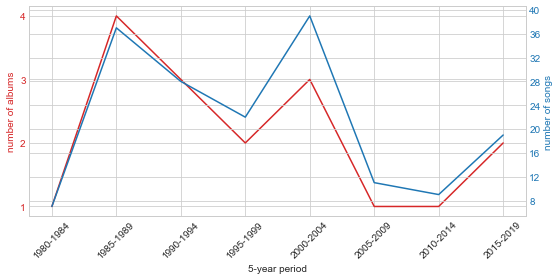

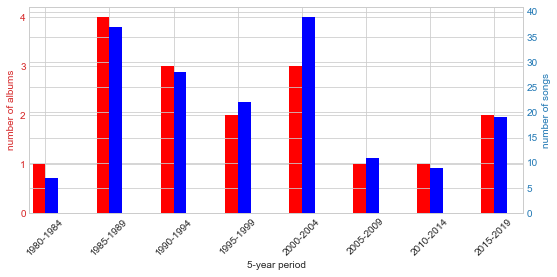

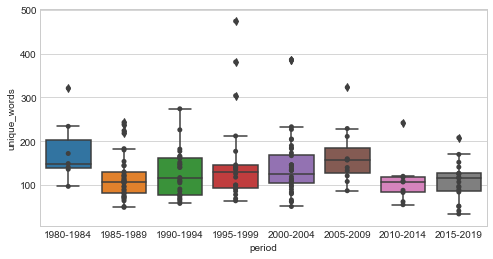

In [1]:
from UI.plots import plots as plots
plots()